In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from sklearn.model_selection import train_test_split

# Data Understanding

Dataset yang digunakan dalam proyek ini merupakan dataset film yang digunakan untuk membangun sistem rekomendasi berdasarkan preferensi pengguna. Dataset ini terdiri dari dua file yaitu movies.csv dan ratings.csv. Pada file movies.csv terdiri dari 3 kolom dengan 9742 baris data. Sedangkan, pada file rating.csv terdiri dari 4 kolom dengan 100836 baris data. Dataset ini diperoleh dari Kaggle melalui tautan berikut: (https://www.kaggle.com/datasets/nicoletacilibiu/movies-and-ratings-for-recommendation-system)

Variabel dalam file movies.csv:
* movieId - ID unik untuk setiap film.
* title - Judul film.
* genres - Genre film (misalnya, aksi, drama, komedi, dll).


Variabel dalam file ratings.csv:
* userId - ID unik untuk setiap pengguna yang memberikan rating.
* movieId - ID film yang diberi rating oleh pengguna.
* rating - Rating yang diberikan oleh pengguna
* timestamp - Waktu ketika rating diberikan.









In [2]:
import pandas as pd

df1 = pd.read_csv('/content/movies.csv')
df2 = pd.read_csv('/content/ratings.csv')
df1

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [3]:
df2

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Kondisi Data Movies.csv:

* variabel title dan genres memiliki tipe data object. Sementara variabel movieId bertipe data Integer.
* Missing Value: Tidak ditemukan nilai yang hilang karena semua kolom memiliki 9742 non-null count.
* Duplikasi: Tidak ada indikasi duplikasi berdasarkan informasi yang diberikan.

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
df1.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


Kondisi Data Ratings.csv:

* Semua variabel berbentuk numerik dengan tipe data int64 (userId, movieId, timestamp) dan int64 (rating).
* Missing Value: Tidak ditemukan nilai yang hilang karena semua kolom memiliki 100836 non-null count.
* Duplikasi: Tidak ada indikasi duplikasi berdasarkan informasi yang diberikan.

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Berdasarkan statiska deskriptif, variabel rating memiliki nilai terkecil 0.5 dan nilai terbesar 5, sehingga rentang nilai rating yang diberikan user antara 0.5 sampai dengan 5

In [7]:
df2.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


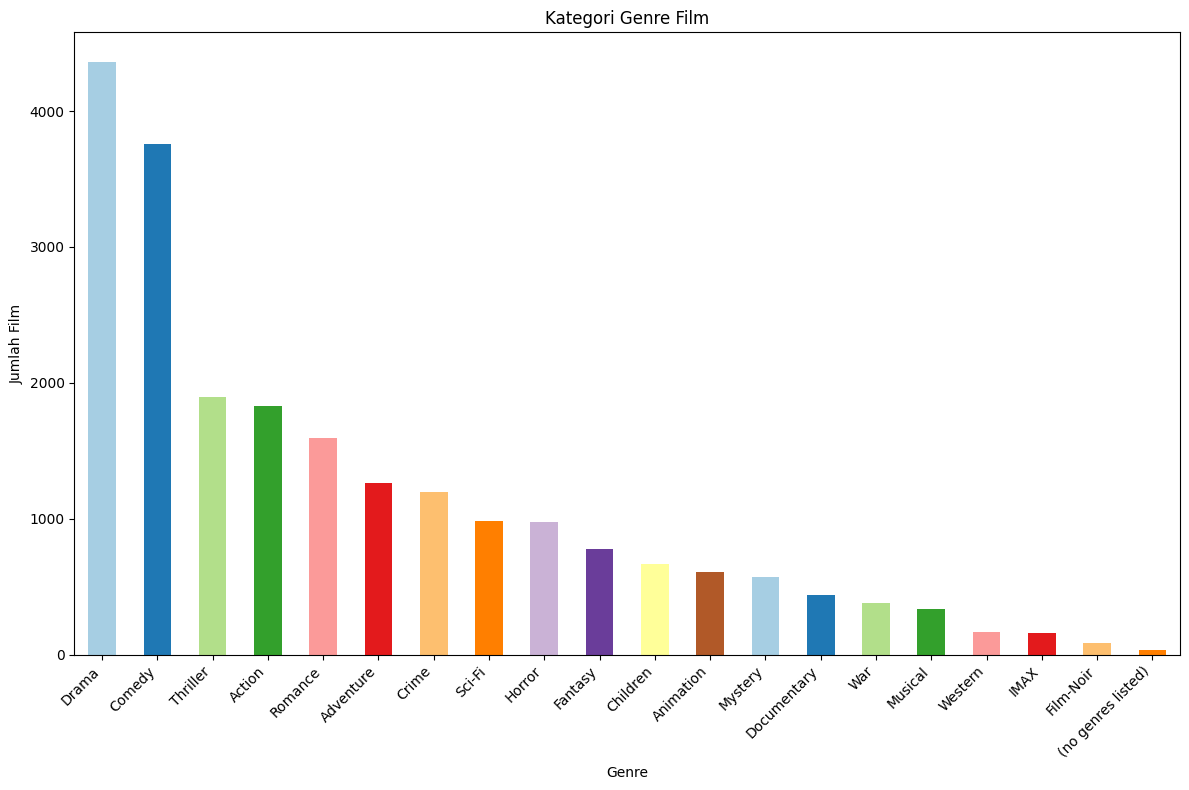

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Memisahkan genre yang digabung dengan "|"
all_genres = df1['genres'].str.split('|').explode()  # Mengubah menjadi satu genre per baris

# Menghitung jumlah kemunculan setiap genre
genre_counts = all_genres.value_counts()

# Visualisasi dengan Diagram Batang
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='bar', color=plt.cm.Paired.colors)
plt.title('Kategori Genre Film')
plt.xlabel('Genre')
plt.ylabel('Jumlah Film')
plt.xticks(rotation=45, ha='right')  # Memiringkan label genre agar lebih mudah dibaca
plt.tight_layout()  # Menyesuaikan layout agar tidak terpotong
plt.show()


Berdasarkan visualisasi grafik batang di atas. Dapat dilihat bahwa genres film terbanyak secara berurutan adalah genre Drama, Comedy, Thriller, Action, dst. Informasi ini dapat digunakan oleh perusahaan penyedia streaming film untuk merekomendasikan film dengan genre-genres tertentu yang memang paling disukai oleh pengguna

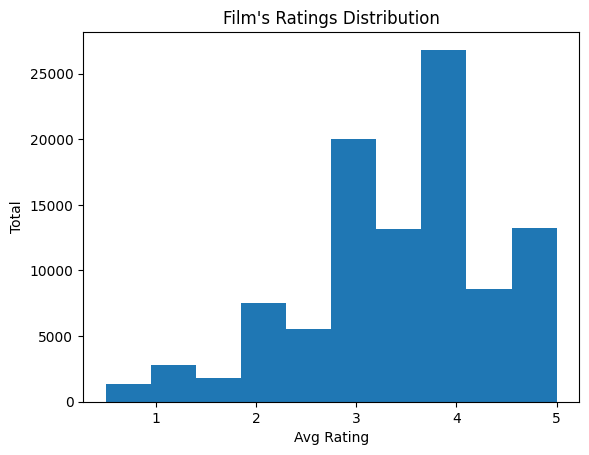

In [9]:
plt.hist(df2.rating)
plt.ylabel('Total')
plt.xlabel('Avg Rating')
plt.title("Film's Ratings Distribution")
plt.show()

Berdasarkan gambar persebaran nilai rating yang diberikan user, terlihat bahwa nilai terbanyak adalah nilai dengan rating 4. Kemudian, disusul dengan nilai rating 3. Sementara itu, nilai terkecil yang diberikan user adalah 0,5 dan nilai terbesar adalah 5.

# Data Preparation

Melakukan konversi dataseries menjadi list menggunakan fungsi tolist() dari library numpy

In [10]:
# Mengonversi data series ‘placeID’ menjadi dalam bentuk list
movieId = df1['movieId'].tolist()

# Mengonversi data series ‘Name’ menjadi dalam bentuk list
title = df1['title'].tolist()

# Mengonversi data series ‘Rcuisine’ menjadi dalam bentuk list
genres = df1['genres'].tolist()

print(len(movieId))
print(len(title))
print(len(genres))

9742
9742
9742


# Model Development Content Based Filtering

Tahap ini akan dibuat dictionary untuk menentukan pasangan key-value pada data movieId, title, dan genres yang telah kita siapkan sebelumnya.

In [11]:
# Membuat dictionary untuk data ‘movies_id’, ‘title’, dan ‘genres’
movies_new = pd.DataFrame({
    'id': movieId,
    'title': title,
    'genres': genres
})
movies_new

,id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [12]:
data = movies_new
data.sample(5)

,id,title,genres
8253,104863,What If (2013),Comedy|Drama|Romance
1542,2077,"Journey of Natty Gann, The (1985)",Adventure|Children
938,1238,Local Hero (1983),Comedy
8133,101612,Admission (2013),Comedy|Romance
8248,104644,Maria Bamford: The Special Special Special! (2...,Comedy


## TF-IDF Vectorizer

Pada tahap ini akan dibuat sistem rekomendasi sederhana berdasarkan jenis genre film menggunakan teknik TF-IDF Vectorizer yang menemukan representasi fitur penting dari setiap kategori genre film

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
tfid = TfidfVectorizer()
tfid.fit(data['genres'])

tfid.get_feature_names_out()


array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

Selanjutnya, akan dilakukan fit dan transformasi ke dalam bentuk matriks.   Output yang dihasilkan berupa matriks berukuran (9724, 24). Nilai 9724 merupakan ukuran data dan 24 merupakan matrik kategori genres film.

In [14]:

tfidf_matrix = tfid.fit_transform(data['genres'])


tfidf_matrix.shape

(9742, 24)

Untuk menghasilkan vektor tf-idf dalam bentuk matriks digunakan fungsi todense().

In [15]:
tfidf_matrix.todense()

matrix([[0.        , 0.41684567, 0.51622547, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51236121, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.57860574, 0.        , 0.81560738, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [16]:

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfid.get_feature_names_out(),
    index=data.title
).sample(24, axis=1).sample(10, axis=0)

,sci,children,fi,musical,genres,fantasy,mystery,thriller,romance,noir,...,imax,adventure,horror,war,listed,comedy,western,crime,film,animation
title,,,,,,,,,,,,,,,,,,,,,
Birdman: Or (The Unexpected Virtue of Ignorance) (2014),0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.734632,0.0,0.0,0.0,0.000000
Maid to Order (1987),0.0,0.000000,0.0,0.000000,0.0,0.874727,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.484617,0.0,0.0,0.0,0.000000
Forbidden Games (Jeux interdits) (1952),0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.920080,0.0,0.000000,0.0,0.0,0.0,0.000000
Syrup (2013),0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.734632,0.0,0.0,0.0,0.000000
Vanity Fair (2004),0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.841423,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
"Peacemaker, The (1997)",0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.465889,0.000000,0.0,...,0.0,0.000000,0.0,0.748345,0.0,0.000000,0.0,0.0,0.0,0.000000
Dr. No (1962),0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.545730,0.000000,0.0,...,0.0,0.629522,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
Peter Pan (1953),0.0,0.478491,0.0,0.567534,0.0,0.457777,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.489277
Caligula (1979),0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000


Output matriks tf-idf di atas menunjukkan hubungan antara film dengan genrenya. Sebagai contoh, film dengan judul Dinner Game, The (Dîner de cons, Le) (1998) memiliki nilai matriks 1.0 pada kategori Comedy. Hal ini berarti film tersebut merupakan film dengan Genres Comedy. Sampai di sini, telah berhasil dilakukan proses identifikasi representasi fitur penting dari setiap kategori genres film dengan fungsi tfidvectorizer sehingga dihasilkan matriks korelasi antara judul film dan kategori genrenya

Selanjutnya, akan dilakukan perhitungan derajat kesamaan antara satu film dengan film lain menggunakan cosine similarity untuk menghasilkan kandidat film yang memiliki kemiripan dan akan direkomendasikan kepada pengguna

In [17]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.81357774, 0.15276924, ..., 0.        , 0.4210373 ,
        0.26758648],
       [0.81357774, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15276924, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57091541],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.4210373 , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.26758648, 0.        , 0.57091541, ..., 0.        , 0.        ,
        1.        ]])

Pada tahapan ini, akan dihitung nilai cosine similarity dataframe tfidf_matrix yang diperoleh pada tahapan sebelumnya menggunakan fungsi cosine similarity dari library sklearn. Output tahap ini berupa matriks kesamaan antar judul film dalam bentuk array.


In [18]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul film
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap film
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9742, 9742)


title,"Public Eye, The (1992)",Tinker Tailor Soldier Spy (2011),Excalibur (1981),Special (2006),Squirm (1976)
title,,,,,
What Lies Beneath (2000),0.0,0.069820,0.000000,0.153060,0.467760
Kung Fu Panda (2008),0.0,0.000000,0.000000,0.000000,0.000000
Earth Girls Are Easy (1988),0.0,0.000000,0.000000,0.000000,0.000000
Sgt. Bilko (1996),0.0,0.000000,0.000000,0.000000,0.000000
All the Pretty Horses (2000),0.0,0.061822,0.000000,0.135525,0.300377
"Emerald Forest, The (1985)",0.0,0.084538,0.448383,0.185323,0.000000
Seven Samurai (Shichinin no samurai) (1954),0.0,0.084538,0.448383,0.185323,0.000000
Seve (2014),0.0,0.083749,0.000000,0.183593,0.000000
Greed (1924),0.0,0.207783,0.000000,0.455501,0.000000


## Mendapatkan Rekomendasi

In [19]:
def movie_recommendations(nama_movie, similarity_data=cosine_sim_df, items=data[['title', 'genres']], k=10):

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_movie].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_movie, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Sebagai contoh, akan diterapkan rekomendasi film yang mirip dengan judul film Dish, The (2001). Film Dist, The (2001) merupakan film dengan genres Comedy sehingga harapannya rekomendasi yang diberikan adalah film yang bergenre Comedy juga

In [20]:
data[data.title.eq('Dish, The (2001)')]

,id,title,genres
3140,4225,"Dish, The (2001)",Comedy


Untuk mendapatkan rekomendasi, tinggal dilakukan pemanggilan terhadap fungsi yang telah didefinisikan sebelumnya

In [21]:
# Mendapatkan rekomendasi film yang mirip dengan Dish, The (2001)
movie_recommendations('Dish, The (2001)')

,title,genres
0,Andrew Dice Clay: Dice Rules (1991),Comedy
1,Little Monsters (1989),Comedy
2,7 Days in Hell (2015),Comedy
3,Gigi (1949),Comedy
4,Loverboy (1989),Comedy
5,The Opposite Sex (2014),Comedy
6,Let It Ride (1989),Comedy
7,Troop Beverly Hills (1989),Comedy
8,Wet Hot American Summer (2001),Comedy
9,Major League (1989),Comedy


Dapat dilihat bahwa sistem telah berhasil merekomendasikan top 10 film yang mirip dengan Dish, The (2001). Semua film yang direkomendasikan memiliki kategori Comedy yang berarti memiliki kesamaan genres dengan film Dish, The (2001)

## Evaluasi Hasil Rekomendasi Content Based Filtering

Metrik evaluasi yang digunakan untuk mengukur hasil rekomendasi Content Based Filtering yaitu Precision. Precision adalah rasio antara jumlah item relevan yang direkomendasikan dengan jumlah total item yang direkomendasikan,  sehingga nantinya fungsi akan mengambil daftar film rekomendasi, membandingkan genre film target dengan genre film rekomendasi, lalu menghitung jumlah film yang relevan dibagi K. Dalam contoh ini, precision bernilai 1.0, yang berarti semua 10 film rekomendasi memiliki minimal satu genre yang sama dengan film "Dish, The (2001)", sehingga hasilnya sempurna.

In [22]:
def precision_at_k(recommended_movies, target_movie, items, k=10):

    target_genres = set(items.loc[items['title'] == target_movie, 'genres'].iloc[0].split('|'))
    recommended_genres = items.loc[items['title'].isin(recommended_movies), 'genres'].apply(lambda x: set(x.split('|')))

    relevancy_count = recommended_genres.apply(lambda x: len(target_genres.intersection(x)) > 0).sum()
    return relevancy_count / k

# Contoh penggunaan
movie_name = "Dish, The (2001)"
recommended_df = movie_recommendations(movie_name, cosine_sim_df, data, k=10)
recommended_movies = recommended_df['title'].tolist()

precision_k = precision_at_k(recommended_movies, movie_name, data, k=10)
print(f'Precision: {precision_k:.2f}')


Precision: 1.00


# Collaborative Filtering

# Data Understanding
Dataset yang digunakan untuk model dengan pendekatan Collaborative Filtering menggunakan data hasil penggabungan dari movies.csv dan ratings.csv. Oleh karena itu, dilakukan penggabungan dua dataframe yaitu movies.csv dan ratings.csv (df2 dan df1) berdasarkan kolom movieId yang ada di kedua dataframe. Proses ini menggunakan metode penggabungan inner join, yang hanya akan menyertakan baris yang memiliki kecocokan pada kolom movieId di kedua dataframe. Hasilnya adalah dataframe baru df yang berisi informasi gabungan dari kedua dataframe tersebut

In [23]:
df = pd.merge(df2, df1, on='movieId', how='inner')
df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


### Pengecekan Missing Value
Tidak ditemukan missing value pada dataframe hasil panggabungan ini

In [25]:
df.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0


### Pengecekan dan Hapus Duplikasi Data

In [26]:
# Membuang data duplikat pada variabel preparation
#df = df.drop_duplicates('movieId')
df = df.drop_duplicates(subset=['movieId', 'userId'])
df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


# Data Preparation

Pada tahap ini dilakukan persiapan data untuk menyandikan (encode) fitur userId dan movieId ke dalam indeks integer

In [27]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df['userId'].unique().tolist()
print('list userId: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

list userId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [28]:
# Mengubah placeID menjadi list tanpa nilai yang sama
movie_ids = df['movieId'].unique().tolist()

# Melakukan proses encoding placeID
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Melakukan proses encoding angka ke placeID
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

Kemudian, dilakukan pemetaan userId dan movieId ke dalam dataframe yang berkaitan

In [29]:
# Mapping userID ke dataframe user
df['user'] = df['userId'].map(user_to_user_encoded)

# Mapping placeID ke dataframe resto
df['movie'] = df['movieId'].map(movie_to_movie_encoded)

Dilakukan tahap pengecekan jumlah user dan jumlah film. Didapatkan bahwa jumlah user sebanyak 610. Sedangkan, jumlah judul film sebanyak 9724

In [30]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

610


In [31]:

# Mendapatkan jumlah film
num_movie = len(movie_encoded_to_movie)
print(num_movie)


9724


Mengubah rating menjadi tipe data float

In [32]:

# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['rating'])

# Nilai maksimal rating
max_rating = max(df['rating'])

print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

Number of User: 610, Number of Movie: 9724, Min Rating: 0.5, Max Rating: 5.0


# Membagi Data untuk Training dan Validasi
pada tahap ini dilakukan pembagian data menjadi data training dan validasi dengan proporsi 80:20. Namun, sebelum melakukan pembagian data training dan validasi perlu dilakukan penentuan variabel fitur dan target. Variabel fiturnya sendiri ada dua yaitu user dan movie. Sedangkan variabel target berupa rating film yang telah dinormalisasi dalam rentang 0 hingga 1 menggunakan Min-Max Scaling

In [33]:
from sklearn.model_selection import train_test_split
# Membuat variabel x untuk mencocokkan data user dan film menjadi satu value
x = df[['user', 'movie']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)


print(x, y)

[[   0    0]
 [   0    1]
 [   0    2]
 ...
 [ 609 3121]
 [ 609 1392]
 [ 609 2873]] [0.77777778 0.77777778 0.77777778 ... 1.         1.         0.55555556]


# Inisasi dan Train Model
Pada tahap ini dilakukan pembuatan model rekomendasi menggunakan RecommenderNet. Model ini menggunakan dua embedding layer untuk merepresentasikan pengguna dan film dalam bentuk vektor laten dengan inisialisasi He Normal agar pelatihan lebih stabil serta regularisasi L2 untuk mencegah overfitting.

Embedding yang telah dibuat kemudian diflatten dan digabungkan menggunakan Concatenate(), sehingga informasi dari pengguna dan film dapat diproses bersama. Model memiliki satu hidden layer dengan 64 neuron dan aktivasi ReLU untuk menangkap hubungan non-linear antara pengguna dan film. Selain itu, terdapat lapisan Dropout 0.6 untuk mencegah overfitting dan Batch Normalization untuk menstabilkan distribusi input. Pada  lapisan output terdiri dari satu neuron tanpa aktivasi yang menghasilkan prediksi rating film.

In [34]:

class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)

        # Embedding Layers dengan Regularisasi Lebih Tinggi
        self.user_embedding = layers.Embedding(
            num_users, embedding_size, embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(0.05)
        )
        self.movie_embedding = layers.Embedding(
            num_movies, embedding_size, embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(0.05)
        )

        # Fully Connected Layers
        self.flatten_user = layers.Flatten()
        self.flatten_movie = layers.Flatten()
        self.concat = layers.Concatenate()

        self.dense1 = layers.Dense(64, activation="relu")  # Kurangi ukuran
        self.dropout = layers.Dropout(0.6)  # Dropout lebih agresif
        self.batch_norm = layers.BatchNormalization()
        self.dense2 = layers.Dense(1)  # Output tanpa sigmoid

    def call(self, inputs):
        user_vector = self.flatten_user(self.user_embedding(inputs[:, 0]))
        movie_vector = self.flatten_movie(self.movie_embedding(inputs[:, 1]))

        x = self.concat([user_vector, movie_vector])
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.batch_norm(x)
        output = self.dense2(x)

        return output

Setelah arsitektur model selesai dibuat, langkah selanjutnya adalah menginisialisasi model dengan embedding size sebesar 50, yang berfungsi untuk merepresentasikan pengguna dan film dalam bentuk vektor laten. Model dikompilasi menggunakan Mean Squared Error (MSE) sebagai fungsi loss karena tugas utamanya adalah regresi, serta menggunakan optimizer Adam dengan learning rate kecil agar pelatihan lebih stabil. Untuk evaluasi, digunakan Root Mean Squared Error (RMSE) yang lebih mudah diinterpretasikan dibandingkan MSE.

Selain itu, digunakan juga dua callback yaitu ReduceLROnPlateau yang menurunkan learning rate secara otomatis saat val_loss stagnan dan EarlyStopping yang menghentikan pelatihan jika val_loss tidak membaik selama beberapa epoch guna mencegah overfitting.

In [35]:
# Inisialisasi Model
embedding_size = 50
model = RecommenderNet(num_users, num_movie, embedding_size)

# Callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True
)

# Compile Model
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.00005),  # Learning rate lebih kecil
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

 Model dilatih dengan batch size 64 dan maksimal 50 epoch menggunakan model.fit(). Dataset validasi digunakan untuk mengevaluasi kinerja model setiap epoch, sementara callback yang telah diterapkan memastikan proses pelatihan tetap optimal dan tidak mengalami penurunan performa.

In [36]:
# Train Model
history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 5.4168 - root_mean_squared_error: 0.5240 - val_loss: 0.8216 - val_root_mean_squared_error: 0.2306 - learning_rate: 5.0000e-05
Epoch 2/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.5500 - root_mean_squared_error: 0.2271 - val_loss: 0.1282 - val_root_mean_squared_error: 0.2261 - learning_rate: 5.0000e-05
Epoch 3/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0947 - root_mean_squared_error: 0.2225 - val_loss: 0.0544 - val_root_mean_squared_error: 0.2208 - learning_rate: 5.0000e-05
Epoch 4/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0521 - root_mean_squared_error: 0.2177 - val_loss: 0.0502 - val_root_mean_squared_error: 0.2139 - learning_rate: 5.0000e-05
Epoch 5/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0487 - root_mean_squared_error: 0.2097 - val_loss: 0.0489 - val_root_mean_squared_error: 0.2088 - learning_rate: 5.0000e-05
Epoch 6/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step 

In [46]:
model.summary()

Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50)                  │          30,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 50)                  │         486,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ concatenate (Concatenate)            │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,570,201 (5.99 MB)

 Trainable params: 523,357 (2.00 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 1,046,716 (3.99 MB)

## Visualisasi Metrik

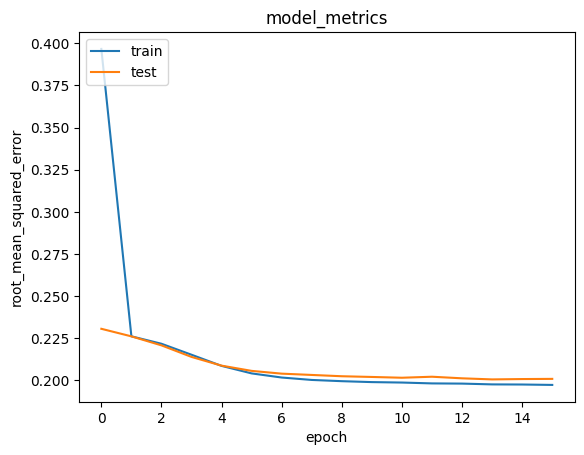

In [37]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Berdasarkan plot grafik tersebut, proses training model cukup smooth dan model konvergen pada epoch sekitar 5. Dari proses ini diperoleh nilai error RMSE akhir pada data training sebesar 0.1973 dan error RMSE pada data validasi sebesar 0.2005. Nilai ini menunjukkan bahwa model memiliki generalisasi yang baik karena perbedaan error antara training dan validasi sangat kecil. Selain itu, tidak terdapat indikasi overfitting karena kurva training dan validasi berjalan sejajar tanpa ada kesenjangan yang signifikan.



In [38]:
# Menampilkan metrik selama pelatihan
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

# Menampilkan hasil metrik
print("RMSE pada Data Pelatihan: ", train_rmse[-1])  # RMSE terakhir pada pelatihan
print("RMSE pada Data Validasi: ", val_rmse[-1])    # RMSE terakhir pada validasi


RMSE pada Data Pelatihan:  0.19732458889484406
RMSE pada Data Validasi:  0.20091010630130768


# Mendapatkan Rekomendasi

Untuk mendapatkan rekomendasi film, pertama-tama sistem akan menerima user_id sebagai input dan memastikan bahwa ID tersebut sudah dalam bentuk terkode.
Selanjutnya, sistem mengambil daftar film yang sudah pernah ditonton oleh pengguna dan menyimpannya dalam variabel watched_movies. Kemudian, daftar movie_ids_to_predict dibuat dengan mengambil seluruh movie yang tersedia lalu menghilangkan film yang sudah ditonton pengguna menggunakan np.setdiff1d()karena sistem hanya akan merekomendasikan film yang belum pernah ditonton.

Setelah itu, ID film yang akan diprediksi dikonversi ke dalam bentuk terkode, lalu dibuat array input dengan menggabungkan ID pengguna yang sudah dikodekan dengan ID film yang akan diprediksi. Model kemudian memprediksi rating untuk setiap film dalam daftar tersebut, dan hasil prediksi ini digunakan untuk menentukan film dengan rating tertinggi.

Akhirnya, sistem mengambil 10 film terbaik berdasarkan prediksi rating tertinggi. Dengan cara ini, rekomendasi yang diberikan lebih personal karena didasarkan pada film yang belum ditonton tetapi memiliki kemungkinan besar untuk disukai pengguna.

In [39]:
def make_recommendation(model, user_id, num_recommendations=10):
    # Memastikan bahwa user_id sudah dalam bentuk terkode
    user_encoded = user_to_user_encoded.get(user_id)
    if user_encoded is None:
        raise ValueError("UserID tidak ditemukan dalam ID pengguna yang terkode.")

    # Mengambil film yang belum pernah ditonton oleh pengguna
    watched_movies = df[df['userId'] == user_id]['movieId'].values
    all_movie_ids = np.array(movie_ids)
    movie_ids_to_predict = np.setdiff1d(all_movie_ids, watched_movies)

    # Melakukan encoding movie ID
    movie_ids_encoded = [movie_to_movie_encoded.get(movie_id) for movie_id in movie_ids_to_predict]

    # Membuat array input untuk prediksi, menggabungkan user dan movie
    user_encoded_array = np.array([user_encoded] * len(movie_ids_encoded))
    movie_ids_encoded_array = np.array(movie_ids_encoded)

    # Gabungkan menjadi satu array dua dimensi
    input_array = np.column_stack((user_encoded_array, movie_ids_encoded_array))

    # Memprediksi rating untuk setiap film yang belum ditonton
    predictions = model.predict(input_array)

    # Mengambil film dengan rating tertinggi
    top_ratings_indices = predictions.flatten().argsort()[-num_recommendations:][::-1]
    recommended_movie_ids_encoded = [movie_ids_encoded_array[x] for x in top_ratings_indices]

    # Mengembalikan ID film yang direkomendasikan
    recommended_movie_ids = [movie_encoded_to_movie.get(movie_encoded) for movie_encoded in recommended_movie_ids_encoded]

    # Menampilkan informasi film yang direkomendasikan
    recommended_movies = df[df['movieId'].isin(recommended_movie_ids)].drop_duplicates(subset='movieId')[['movieId', 'title','genres']]
    return recommended_movies


In [40]:
# Memilih ID pengguna acak
random_user_id = np.random.choice(user_ids)

# Tampilkan film teratas yang dinilai oleh user
top_rated_movies_by_user = df[df['userId'] == random_user_id].sort_values(by='rating', ascending=False).head(5)

# Menampilkan rekomendasi untuk pengguna acak
recommended_movies = make_recommendation(model, random_user_id, num_recommendations=10)

# Menampilkan top film by user
print(f"Film Teratas yang Dinilai oleh User: {random_user_id}")
display(top_rated_movies_by_user[['userId', 'rating', 'title', 'genres']])

# Menampilkan hasil rekomendasi
print("\n")
print(f"Rekomendasi film untuk User: {random_user_id}")
display(recommended_movies[['title','genres']])



303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Film Teratas yang Dinilai oleh User: 121


,userId,rating,title,genres
18775,121,5.0,Heat (1995),Action|Crime|Thriller
18777,121,5.0,Casino (1995),Crime|Drama
18806,121,5.0,"Shawshank Redemption, The (1994)",Crime|Drama
18784,121,5.0,Mr. Holland's Opus (1995),Drama
18773,121,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy




Rekomendasi film untuk User: 121


,title,genres
4,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
67,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
71,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller
83,"Shining, The (1980)",Horror
240,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
351,Rear Window (1954),Mystery|Thriller
388,Unforgiven (1992),Drama|Western
1453,"Godfather, The (1972)",Crime|Drama
1618,Cool Hand Luke (1967),Drama
1707,"Godfather: Part II, The (1974)",Crime|Drama


Model berhasil memberikan rekomendasi film kepada user. Sebagai contoh, hasil di atas adalah rekomendasi untuk user dengan id 113. Dari output tersebut,dapat dibandingkan antara Film with high ratings from user dan Top 10 film recommendation untuk user. Dapat dilihat bahwa beberapa film rekomendasi memiliki genres yang sesuai dengan rating user.



# Dampak terhadap Business Understanding

Sistem rekomendasi film yang dikembangkan memiliki dampak signifikan terhadap pemahaman bisnis, terutama dalam hal meningkatkan pengalaman pengguna di platform streaming. Berikut adalah beberapa aspek utama dampaknya:
1.   Menjawab Problem Statement dan Mencapai Goals
*   Sistem rekomendasi film dengan pendekatan Content Based Filtering berhasil memberikan Top-N rekomendasi film berdasarkan genre favorit pengguna
*   Sistem rekomendasi film dengan pendekatan Collaborative Filtering berhasil memberikan rekomendasi film yang belum pernah ditonton oleh pengguna berdasarkan rating yang telah diberikan
*   Berdasarkan evaluasi menggunakan metrik Precision pada sistem rekomendasi Content Based Filterting dan RMSE pada sistem rekomendasi Collaborative Filtering menunjukkan bahwa kedua model sistem rekomendasi memiliki kinerja yang baik dalam memberikan rekomendasi yang relevan dan akurat, serta memenuhi tujuan untuk memberikan rekomendasi film yang lebih personal dan sesuai dengan preferensi pengguna.

2.   Dampak dari Solusi Statement
*   Sistem Rekomendasi dengan pendeketan Content Based Filtering dan Collaborative Filtering keduanya berhasil memberikan hasil rekomendasi yang akurat dan relevan yang dibuktikan dengan nilai Evaluasi menggunakan metrik Precision untuk Content-Based Filtering dan RMSE untuk Collaborative Filtering menunjukkan nilai yang sangat baik.
*  Dengan adanya sistem rekomendasi film ini, dapat dijadikan pertimbangan bagi pihak platform streaming film dalam meningkatkan pengalaman pengguna dengan cara yang lebih personal dan menyenangkan sehingga mendorong pengguna untuk lebih lama bertahan di platform dan memperbesar peluang peningkatan engagement.


# Kesimpulan

Model dengan pendekatan Content-Based Filtering dan Collaborative Filtering mampu memberikan rekomendasi yang relevan dengan baik kepada pengguna.
Content-Based Filtering lebih fokus pada kesamaan genre film yang sudah ditonton pengguna, sementara Collaborative Filtering berbasis jaringan saraf, memanfaatkan pola rating dari pengguna lain untuk menyarankan film yang belum pernah ditonton. Kedua pendekatan ini memberikan nilai tambah bagi platform streaming sehingga diharapkan dapat meningkatkan pengalaman pengguna dengan rekomendasi yang lebih personal dan sesuai selera.